In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import random
import os

In [2]:
with open('../Data/preprocessed.pkl.zip', 'rb') as f:
    _ = pickle.load(f)
    col_names = pickle.load(f)
    X = pickle.load(f)
    y = pickle.load(f)
    cat_slice = pickle.load(f)
    skewed_slice = pickle.load(f)
    non_skewed_slice = pickle.load(f)

    X_train = pickle.load(f)
    X_test = pickle.load(f)
    y_train = pickle.load(f)
    y_test = pickle.load(f)    

In [3]:
col_names, X.shape, y.shape, cat_slice, skewed_slice, non_skewed_slice

(array(['_STATE_1.0', '_STATE_2.0', '_STATE_4.0', ..., 'HTM4',
        'MAXVO2__ALT', 'FC60__ALT'], dtype=object),
 (437514, 1579),
 (437514,),
 slice(0, 1525, None),
 slice(1525, 1573, None),
 slice(1573, 1579, None))

In [4]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #X_cat = X[:, cat_slice]
        #X_skewed = X[:, skewed_slice]
        #X_non_skewed = X[:, non_skewed_slice]
        
        #q_transformer = QuantileTransformer()
        #q_transformer.fit(X_skewed)

        X = sparse.hstack([X[:, cat_slice], QuantileTransformer().fit_transform(X[:, skewed_slice]), X[:, non_skewed_slice]], format='csr')
        
        #Making the matrices dense
        #X_non_skewed_dense = X_non_skewed.toarray()

        #Initializing and fitting the scaler
        #scaler = StandardScaler()
        #scaler.fit(X_non_skewed_dense)

        #Applying the scaling t+
        # eo the dense matrices
        #X_non_skewed_dense = scaler.transform(X_non_skewed_dense)

        #Making the matrices sparse again
        #X_non_skewed = sparse.csr_matrix(X_non_skewed_dense)
        
        #X_non_skewed = sparse.csr_matrix(StandardScaler().fit_transform(X[:, non_skewed_slice].toarray())) 
        X = sparse.hstack([X[:, cat_slice], X[:, skewed_slice], sparse.csr_matrix(StandardScaler().fit_transform(X[:, non_skewed_slice].toarray()))], format='csr')
        
        #del X_non_skewed
        
        #X = sparse.hstack([X_cat, X_skewed, X_non_skewed])
        
        return X

In [5]:
pipeline = Pipeline([('transformation', CustomTransformer()), ('log_regression', LogisticRegression(max_iter=10000))])

In [6]:
%%time

cv_scores = cross_val_score(pipeline, X, y, scoring='roc_auc')

: 

: 

In [3]:
path = '../Data/first_log_model.pkl'
if not os.path.exists(path):
    logistic_regressor = LogisticRegression(max_iter=10000)
    logistic_regressor.fit(X_train, y_train)
    with open(path, 'wb') as f:
        pickle.dump(logistic_regressor, f)
else:
    with open(path, 'rb') as f:
        logistic_regressor = pickle.load(f)

In [4]:
y_pred = logistic_regressor.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     79776
         1.0       0.58      0.17      0.26      7727

    accuracy                           0.92     87503
   macro avg       0.75      0.58      0.61     87503
weighted avg       0.89      0.92      0.89     87503



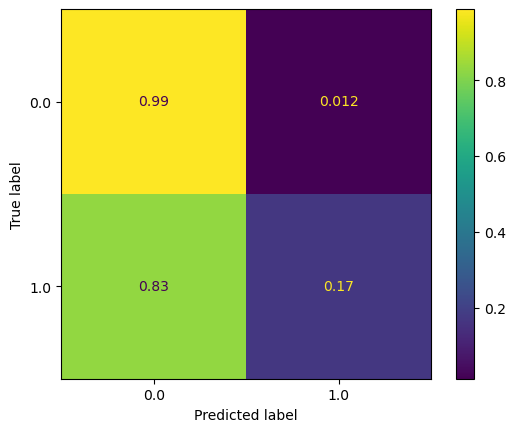

In [5]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

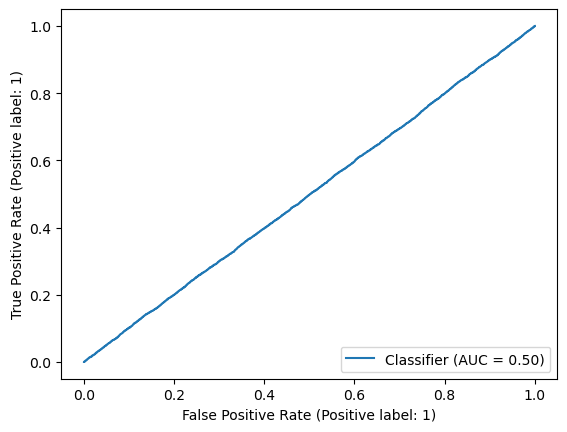

In [6]:
y_pred_rand = [random.uniform(0, 1) for x in y_test]
RocCurveDisplay.from_predictions(y_test, y_pred_rand)
plt.show()

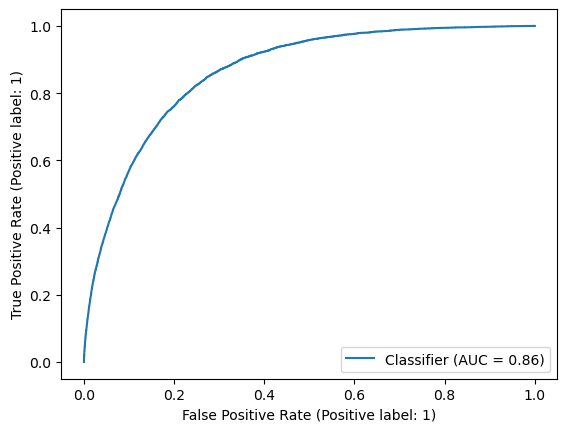

In [7]:
y_pred_prob = logistic_regressor.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.show()

In [8]:
def plot_logistic_feature_importance(coefficients, feature_names, number):
    coef_enum = enumerate(coefficients)
    coef_enum_sorted_top = sorted(coef_enum, key=lambda x: abs(x[1]), reverse=True)[:number]
    
    indices = list(list(zip(*coef_enum_sorted_top))[0])
    names = feature_names[indices]
    top_coef = np.array(list(zip(*coef_enum_sorted_top))[1])
    
    neg_pos = np.where(top_coef < 0)[0]
    pos_pos = np.where(top_coef >= 0)[0]
    neg_coef = top_coef[neg_pos]
    pos_coef = top_coef[pos_pos]
    neg_names = names[neg_pos]
    pos_names = names[pos_pos]
    
    _, ax = plt.subplots()
    
    ax.bar(neg_pos, np.abs(neg_coef), color='r', label='negative')
    ax.bar(pos_pos, np.abs(pos_coef), color='b', label='positive')
    ax.set_xticks(range(0, len(names)))
    ax.set_xticklabels(names, rotation=90)
    ax.set_title('Top Features by Absolute Value of Model Coefficient')
    ax.set_ylabel('Feature Coefficient')
    ax.set_xlabel('Features')
    
    ax.legend()
    plt.show()

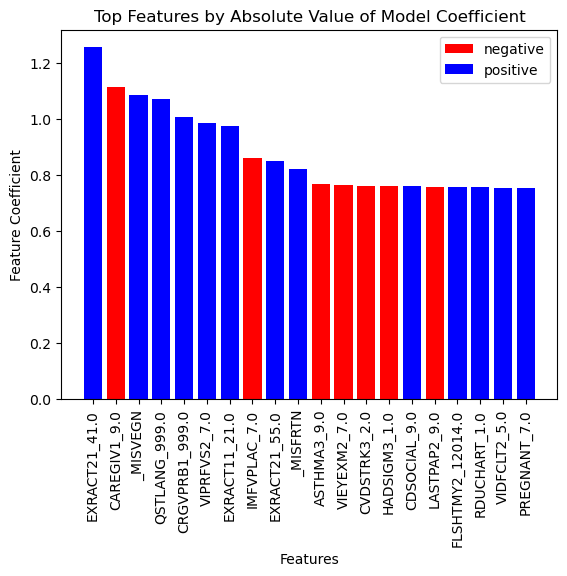

In [9]:
plot_logistic_feature_importance(logistic_regressor.coef_[0], col_names, 20)

In [ ]:
cv_score_list = cross_val_score(logistic_regressor, X_train, y_train, scoring='roc_auc')
print(f'CV scores: {cv_score_list}\nAverage: {cv_score_list.mean()}\nStandard Deviation: {cross_val_score.std()}')

In [ ]:
print(f'CV Scores: {cv_score_list}\nAverage: {cv_score_list.mean()}\nStandard Deviation: {cv_score_list.std()}')